In [65]:
import numpy as np
from sequence_pairs import SampleList
from cgr_model import scale_cgrs
from os.path import join, exists
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from tensorflow import keras
import tensorflow as tf
from keras import layers

# Synthetic data
## Synonymous mutations

In [12]:
# Example of adding synonymous synthetic data to a dataset
# Load original data
data = np.load('data/0000_datasets_as_used_in_paper/Arabidopsis_thaliana/AtGrand_4mers.npz', allow_pickle=True)
example_data = SampleList(list(data['training']))
print(len(example_data.sample_list))
# Add 10 synthetic versions of every real pair
example_data.add_synthetic_data(10)
print(len(example_data.sample_list))

663
7293


### Results

Each parameter set tested in the Arabidopsis thaliana parameter search was tested with the synthetic data included in the training data, but not the validation data. Reading and plotting the results:

In [27]:
cgr_exp_dir_resnet_synth = 'data/0008_synthetic_data/synonymous_mutation_results'
df_list = []
for k in range(4,10):
    for i in range(1000):
        fname = join(cgr_exp_dir_resnet_synth, f'AtGrand_{k}mers_{i}_10x_synthetic.csv')
        if exists(fname):
            res_df = pd.read_csv(fname)
            res_df['k']=k
            df_list.append(res_df)
exp_resnet_synth_df = pd.concat(df_list, ignore_index=True)
exp_means_df_resnet_synth = exp_resnet_synth_df.groupby('seed_i', as_index=False).mean()

# Reading in results without synthetic data
cgr_exp_dir_resnet = 'data/0003_results_of_ppi_prediction_parameter_search/Arabidopsis_thaliana'
df_list = []
for k in range(4,8):
    for i in range(1000):
        fname = join(cgr_exp_dir_resnet, f'AtGrand_{k}mers_{i}.csv')
        if exists(fname):
            res_df = pd.read_csv(fname)
            res_df['k']=k
            df_list.append(res_df)
exp_resnet_df = pd.concat(df_list, ignore_index=True)
exp_means_df_resnet = exp_resnet_df.groupby(['seed_i','k'], as_index=False).mean()


In [30]:
def plot_synth_comparison(query_suffix):
    xs=[]
    ys=[]
    for i in range(1000):
        row_x = exp_means_df_resnet.query(f'seed_i=={i} and k==4{query_suffix}')
        row_y = exp_means_df_resnet_synth.query(f'seed_i=={i}{query_suffix}')
        if len(row_x) > 0 and len(row_y) > 0:
            xs.append(float(row_x['max_val_acc']))
            ys.append(float(row_y['max_val_acc']))
    if len(xs)>0:
        plt.scatter(xs,ys)
        xmin = np.min(xs + ys)
        xmax = np.max(xs + ys)
        plt.plot([xmin,xmax],[xmin,xmax],'k--')
        lowess = sm.nonparametric.lowess
        lowess_line = lowess(ys,xs)
        plt.plot(lowess_line[:,0],lowess_line[:,1],'r')
        plt.legend(['One parameter set','x=y','LOWESS curve'])
        plt.xlabel('Original mean accuracy')
        plt.ylabel('Mean accuracy with synthetic data')
        xsnp=np.array(xs)
        ysnp=np.array(ys)
        print(np.count_nonzero(xsnp<ysnp)/len(xsnp))
        print(np.count_nonzero(ysnp<xsnp)/len(xsnp))
        print(np.count_nonzero(xsnp==ysnp)/len(xsnp))

Scatterplot that compares the validation results for the same set of parameters with and without the inclusion of synonymous mutations in the training dataset

0.23210161662817552
0.7344110854503464
0.03348729792147806


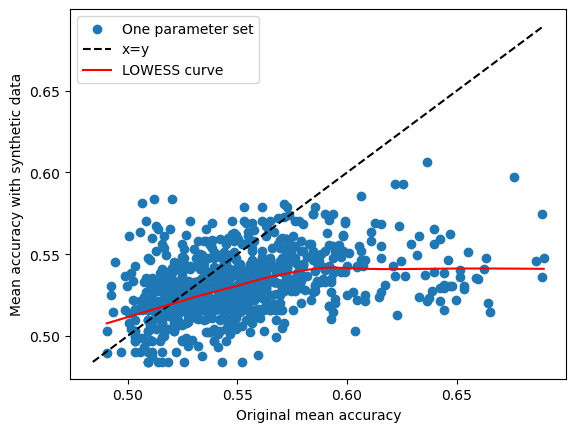

In [33]:
plot_synth_comparison('')

## Conditional GANS
### Generation

In [58]:
batch_size = 64
num_channels = 2
num_classes = 2
k=4
image_size = 2**k
latent_dim = 128

# Adapted from conditional GANs tutorial
# Load in the data as all_digits and all_labels
data = np.load('data/0000_datasets_as_used_in_paper/Arabidopsis_thaliana/AtGrand_4mers.npz')
all_digits = scale_cgrs(data['training_x'])
all_digits=all_digits.astype('float32')

# one-hot encode the labels
all_labels = keras.utils.to_categorical(data['training_y'], 2)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024, reshuffle_each_iteration=True).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (663, 16, 16, 2)
Shape of training labels: (663, 2)


2023-09-14 18:29:27.490685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [60]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

In [63]:
def make_fake_image(image_class, seed=0, show=True):
    tf.random.set_seed(seed)
    new_target = tf.cast(keras.utils.to_categorical([image_class], 2), tf.float32)
    interpolation_noise = tf.random.normal(shape=(1, latent_dim),seed=seed)
    noise_and_labels = tf.concat([interpolation_noise, new_target], 1)
    fake = trained_gen.predict(noise_and_labels)
    if show:
        if image_class==0:
            cmap='Reds'
        else:
            cmap='Blues'
        fig=plt.figure(figsize=(9,6))
        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(fake[0,:,:,0],cmap=cmap)
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(fake[0,:,:,1],cmap=cmap)
        plt.show()
    return fake

def new_generator(gen_size):
    generator = keras.Sequential(
        [
            keras.layers.InputLayer((generator_in_channels,)),
            layers.Dense(gen_size * gen_size * generator_in_channels),
            layers.LeakyReLU(alpha=0.2),
            layers.Reshape((gen_size, gen_size, generator_in_channels)),
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(2, (gen_size, gen_size), padding="same", activation="sigmoid"),
        ],
        name="generator",
    )
    return generator

def new_discriminator():
    discriminator = keras.Sequential(
        [
            keras.layers.InputLayer((image_size, image_size, discriminator_in_channels)),
            layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same"),
            layers.LeakyReLU(alpha=0.2),
    #        layers.Dropout(0.2),
            layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.GlobalMaxPooling2D(),
    #        layers.Dropout(0.5),
            layers.Dense(1),        
        ],
        name="discriminator",
    )
    return discriminator


class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        
        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

1/1 [==============================] - 0s 76ms/step


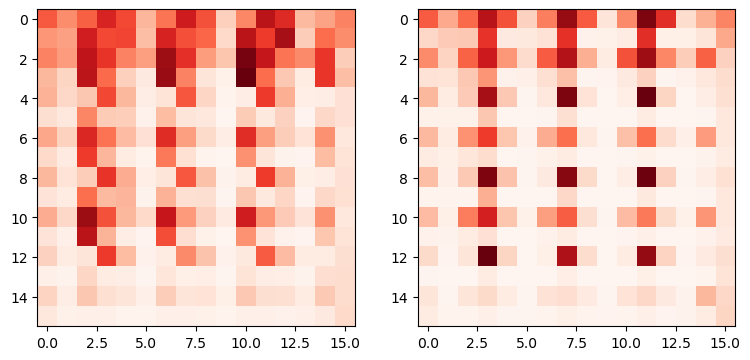

1/1 [==============================] - 0s 30ms/step


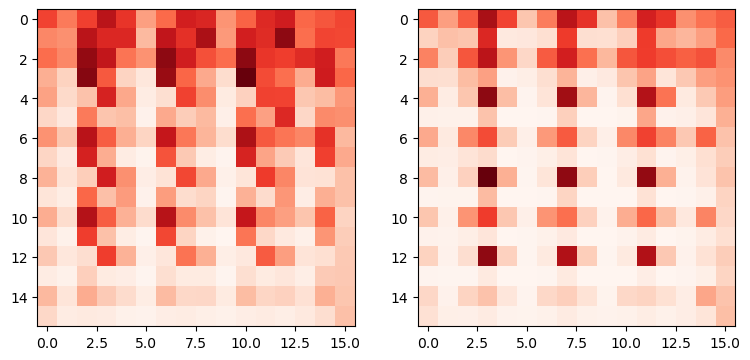

1/1 [==============================] - 0s 29ms/step


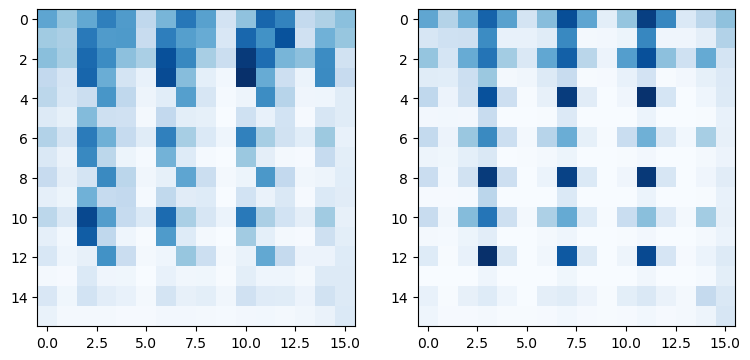

1/1 [==============================] - 0s 29ms/step


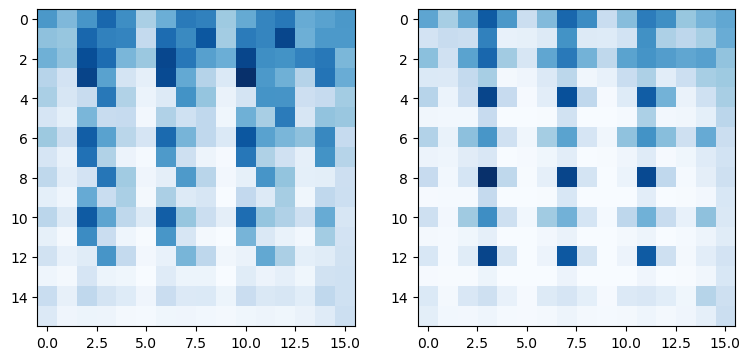

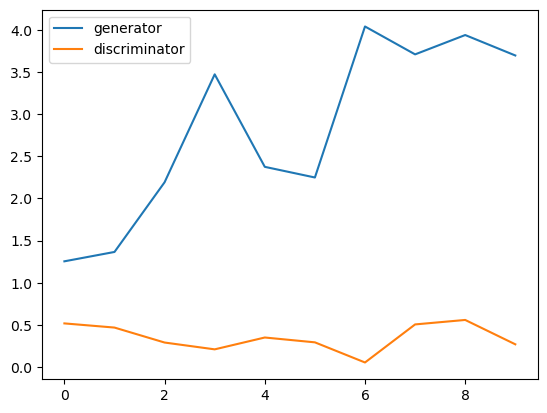

1/1 [==============================] - 0s 33ms/step


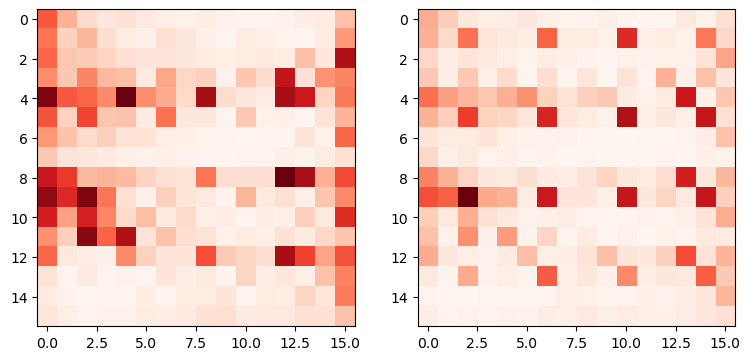

1/1 [==============================] - 0s 32ms/step


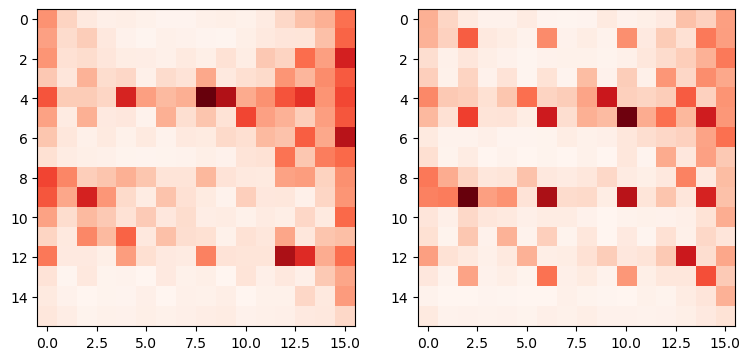

1/1 [==============================] - 0s 29ms/step


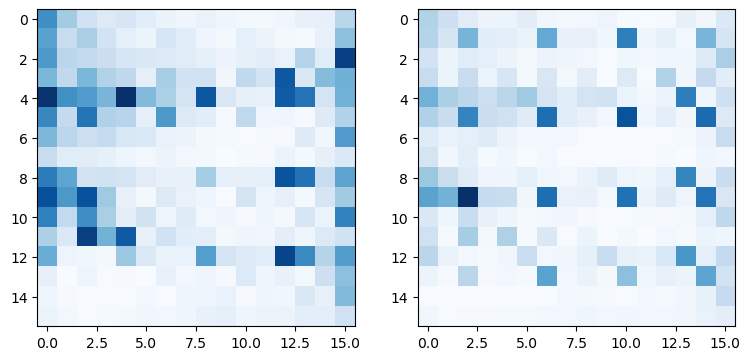

1/1 [==============================] - 0s 31ms/step


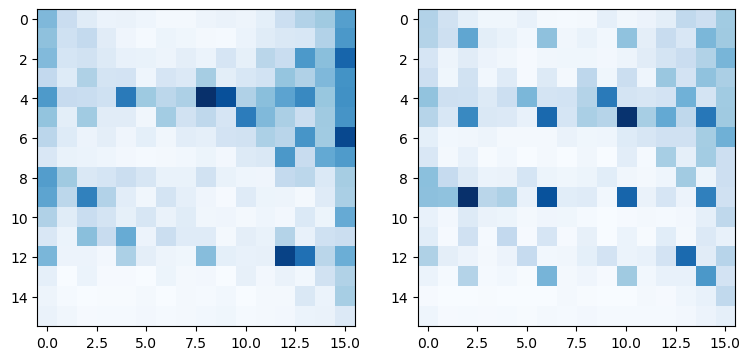

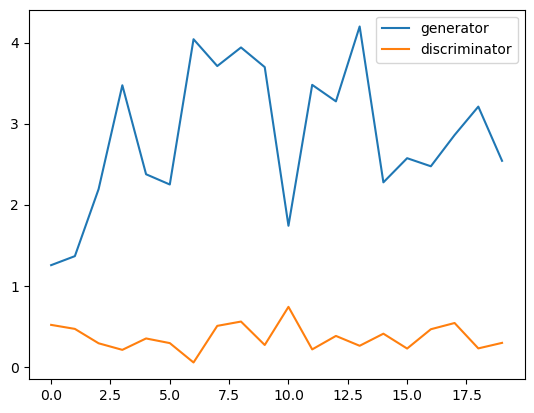

1/1 [==============================] - 0s 28ms/step


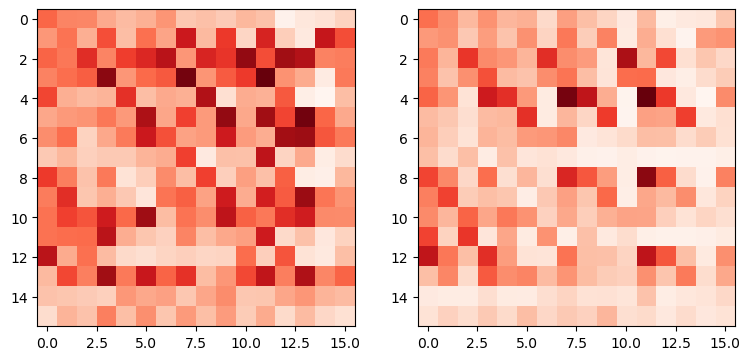

1/1 [==============================] - 0s 29ms/step


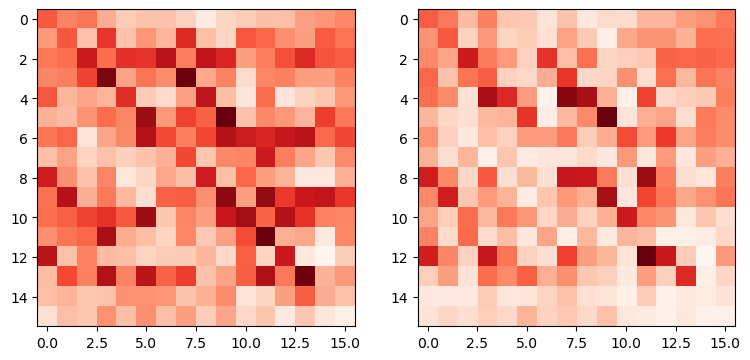

1/1 [==============================] - 0s 31ms/step


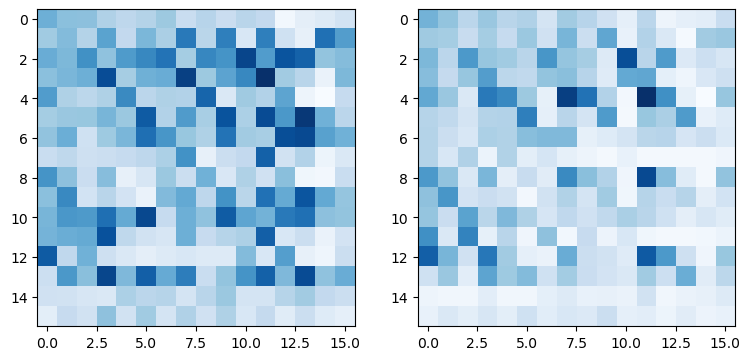

1/1 [==============================] - 0s 28ms/step


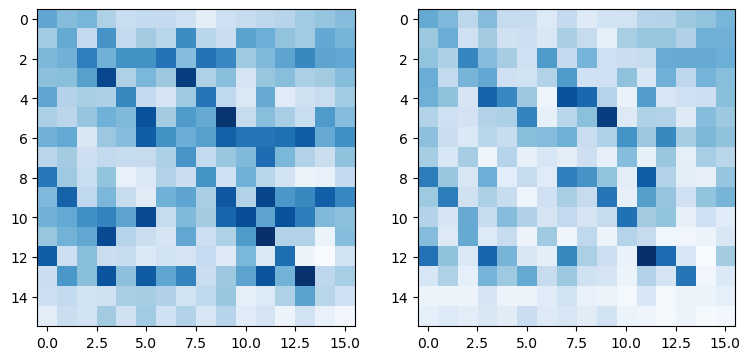

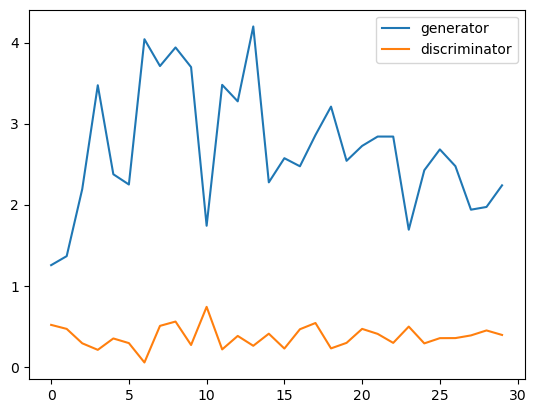

1/1 [==============================] - 0s 28ms/step


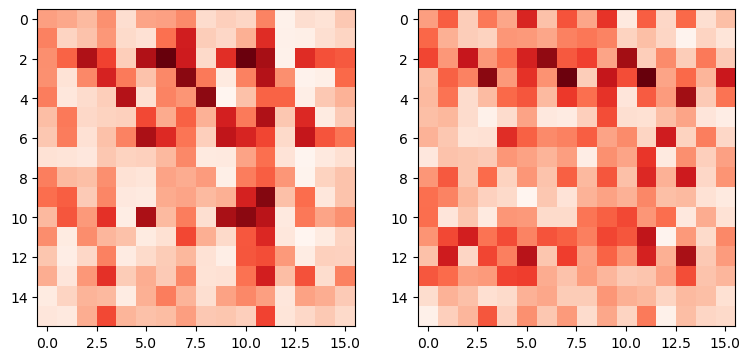

1/1 [==============================] - 0s 28ms/step


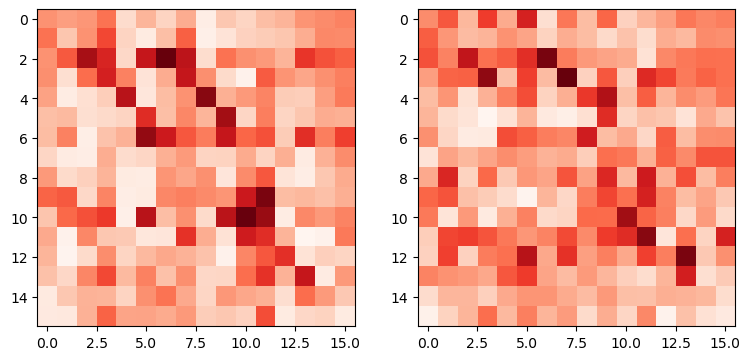

1/1 [==============================] - 0s 29ms/step


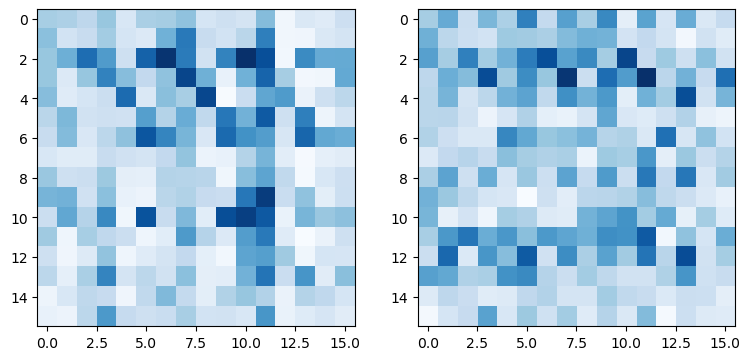

1/1 [==============================] - 0s 28ms/step


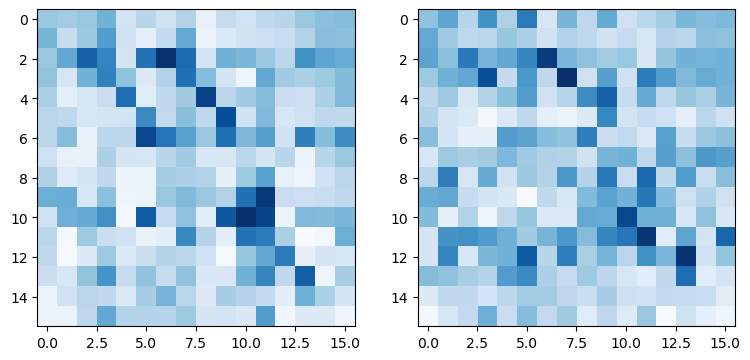

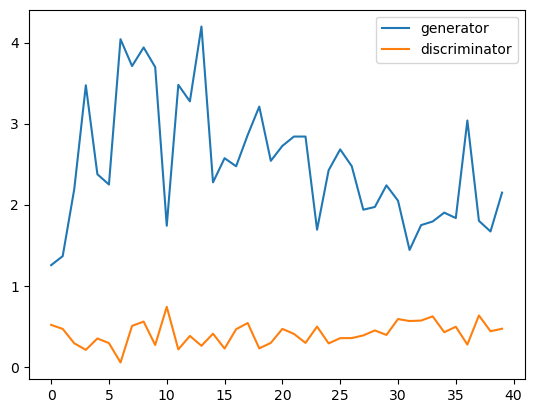

1/1 [==============================] - 0s 35ms/step


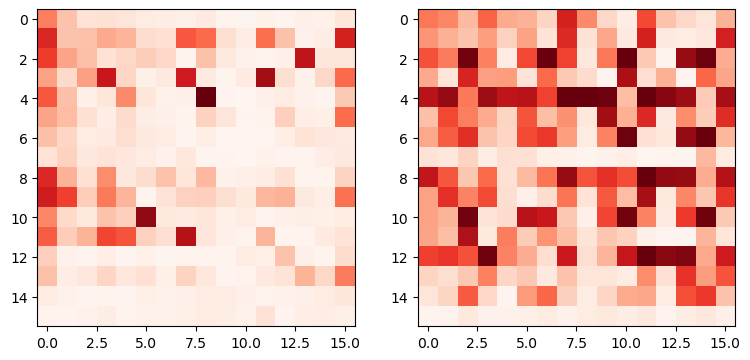

1/1 [==============================] - 0s 31ms/step


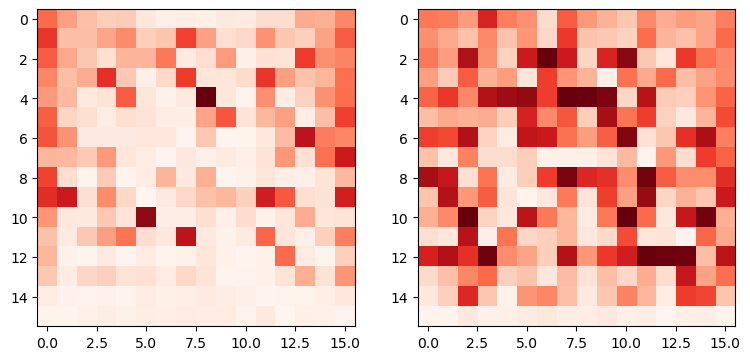

1/1 [==============================] - 0s 30ms/step


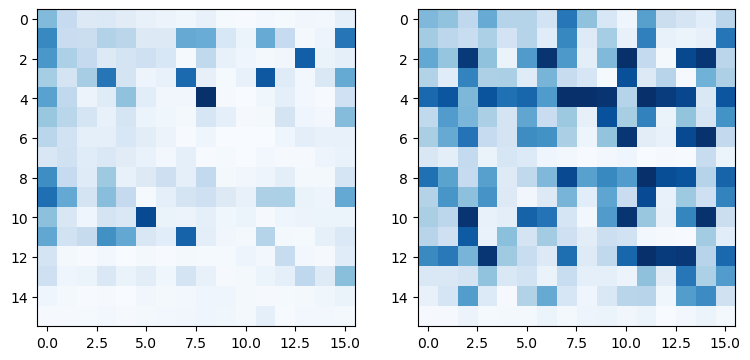

1/1 [==============================] - 0s 31ms/step


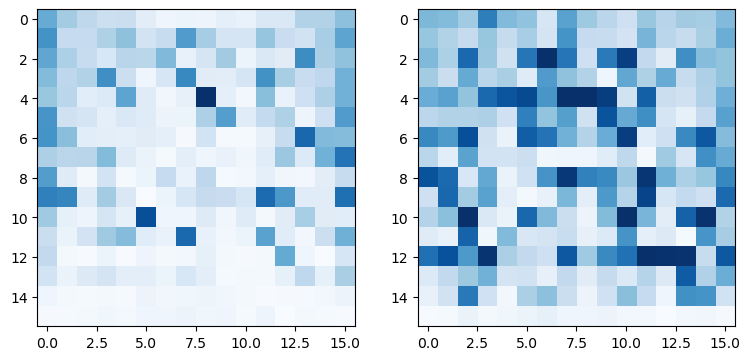

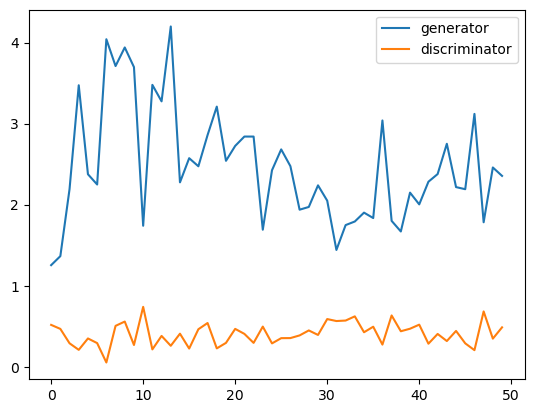

1/1 [==============================] - 0s 29ms/step


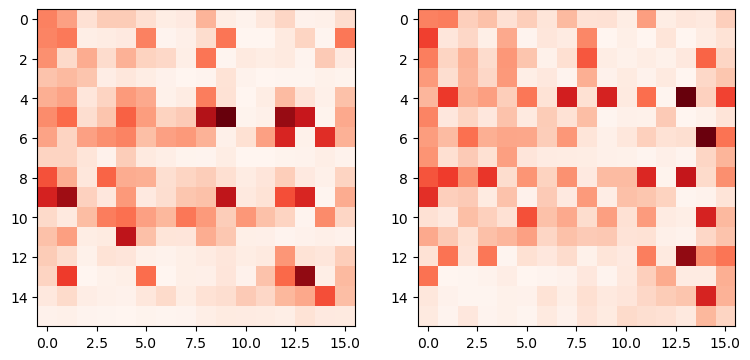

1/1 [==============================] - 0s 28ms/step


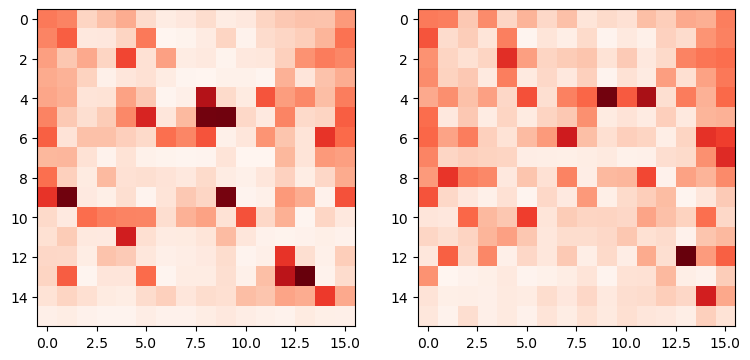

1/1 [==============================] - 0s 32ms/step


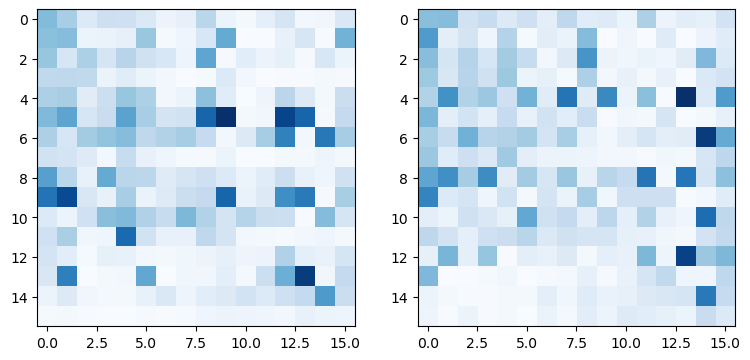

1/1 [==============================] - 0s 31ms/step


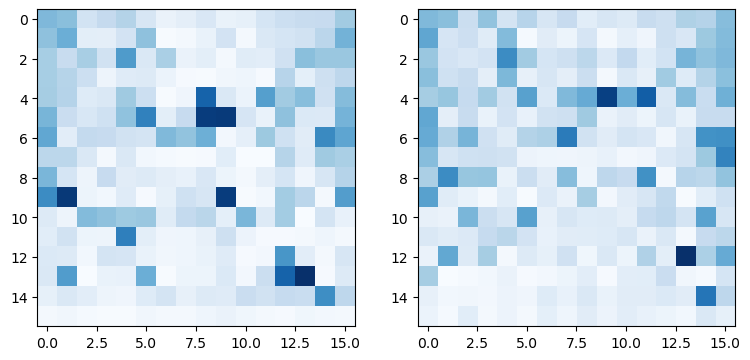

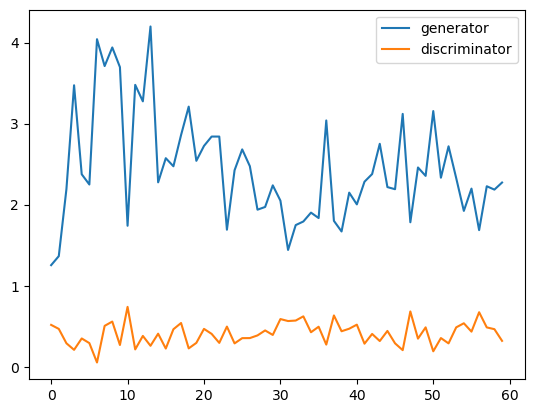

1/1 [==============================] - 0s 31ms/step


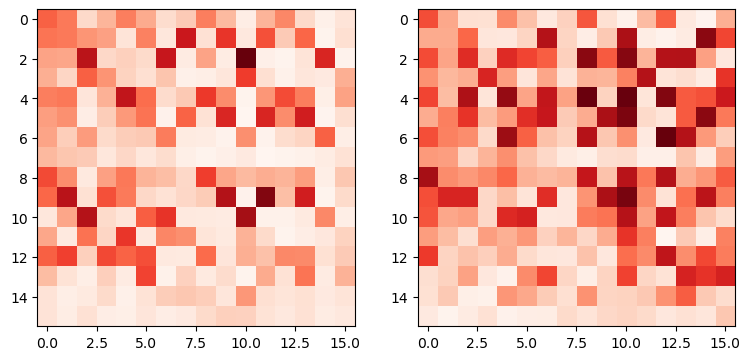

1/1 [==============================] - 0s 32ms/step


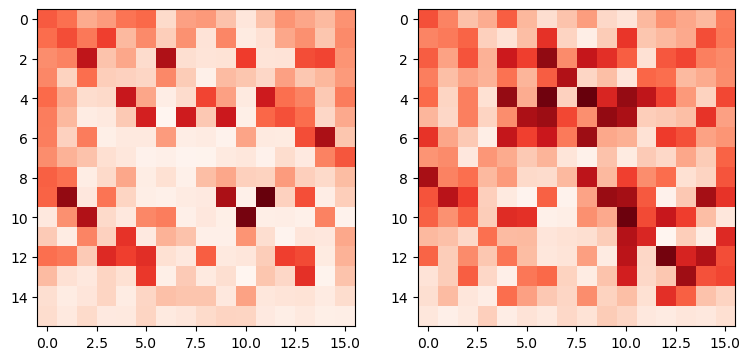

1/1 [==============================] - 0s 30ms/step


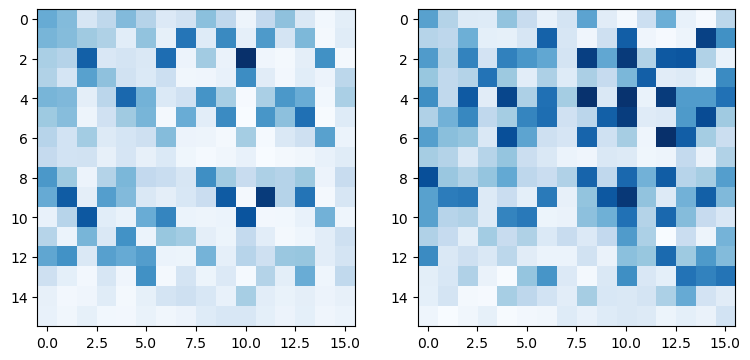

1/1 [==============================] - 0s 31ms/step


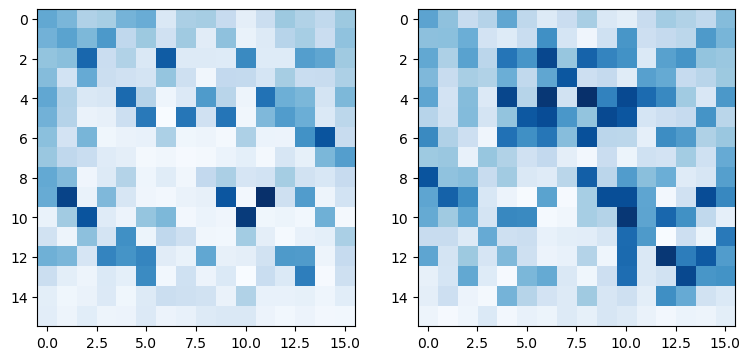

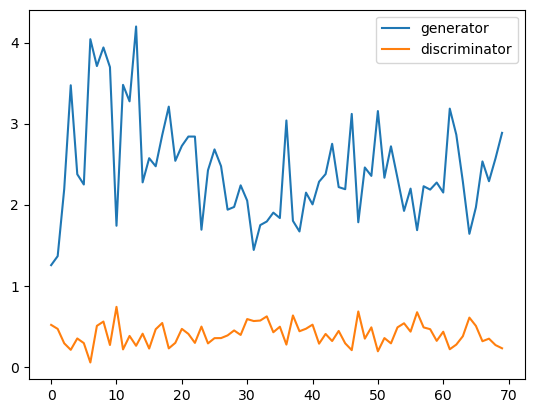

1/1 [==============================] - 0s 30ms/step


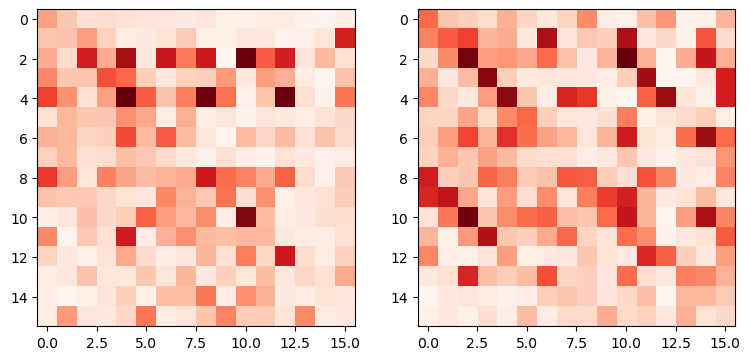

1/1 [==============================] - 0s 29ms/step


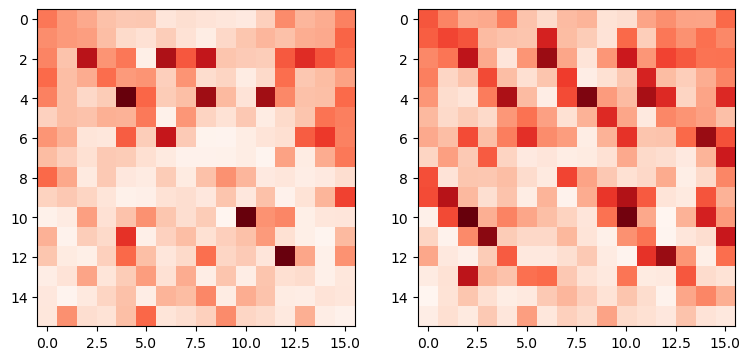

1/1 [==============================] - 0s 32ms/step


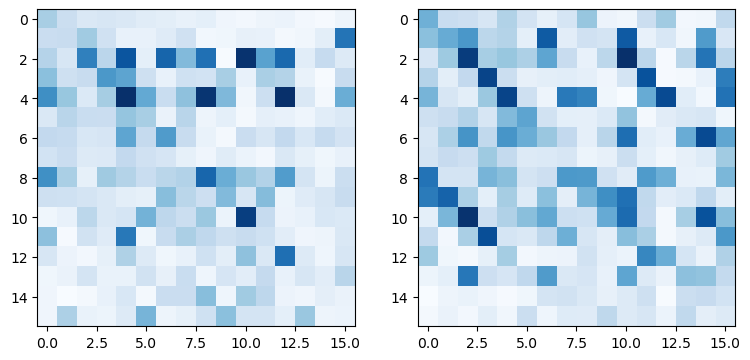

1/1 [==============================] - 0s 31ms/step


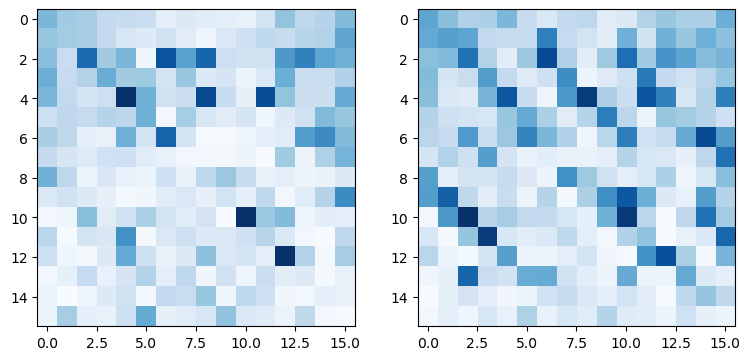

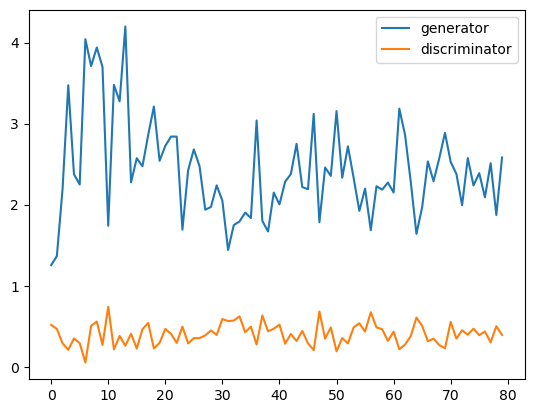

1/1 [==============================] - 0s 29ms/step


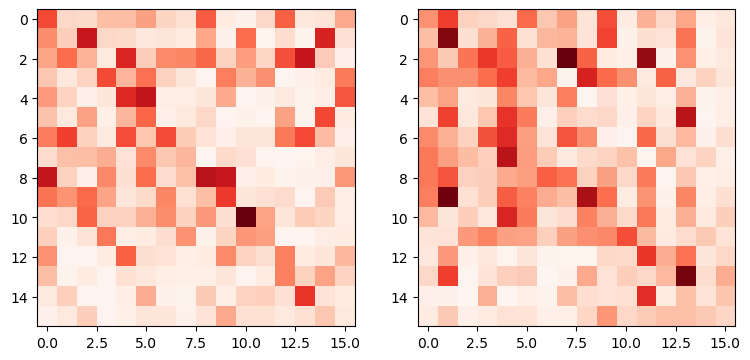

1/1 [==============================] - 0s 29ms/step


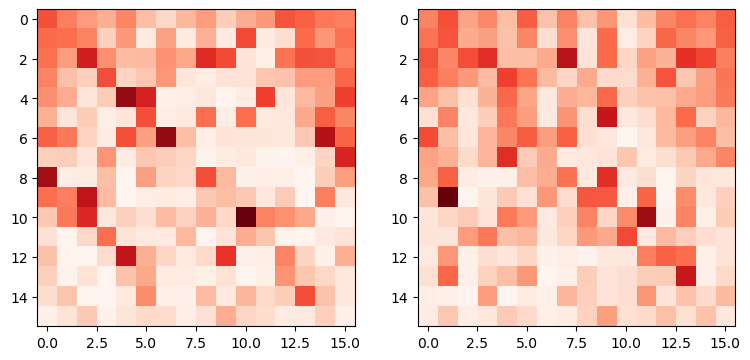

1/1 [==============================] - 0s 34ms/step


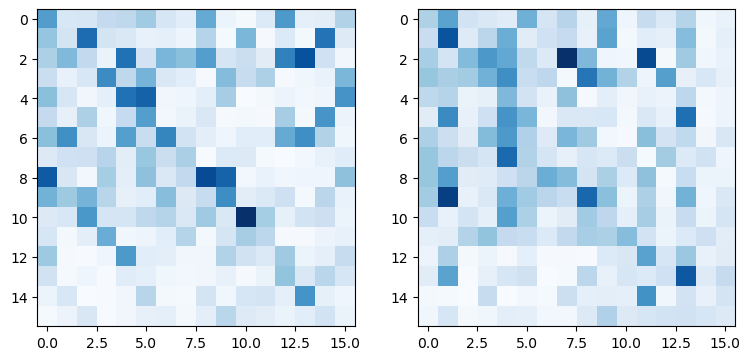

1/1 [==============================] - 0s 29ms/step


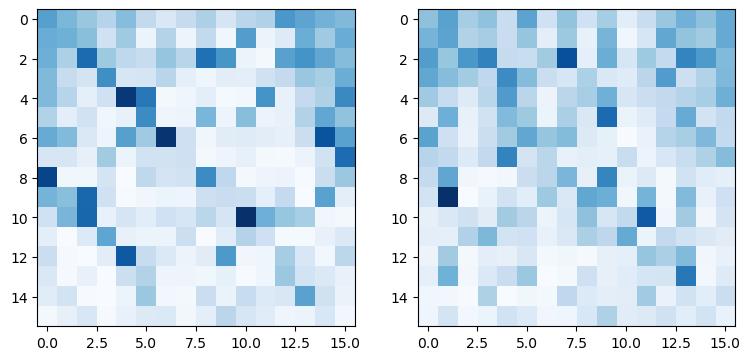

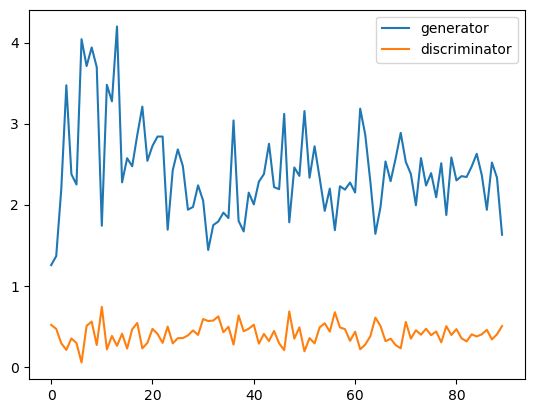

1/1 [==============================] - 0s 28ms/step


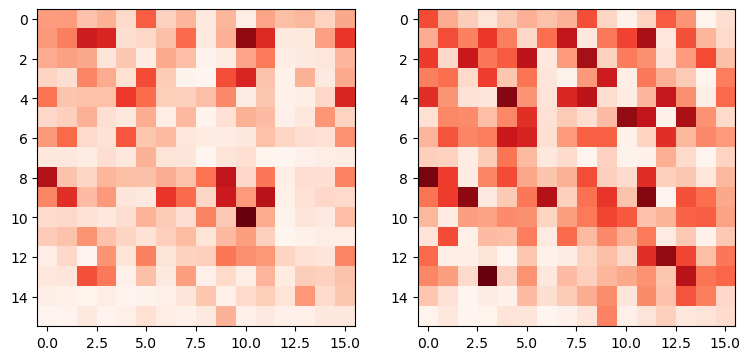

1/1 [==============================] - 0s 29ms/step


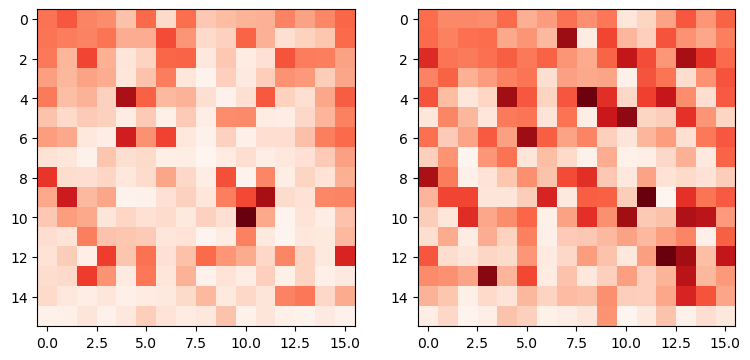

1/1 [==============================] - 0s 28ms/step


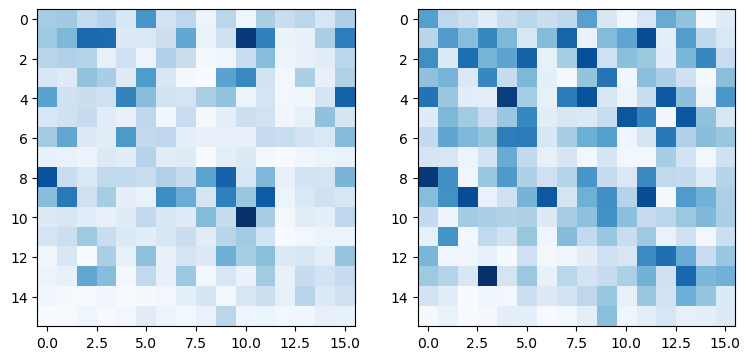

1/1 [==============================] - 0s 28ms/step


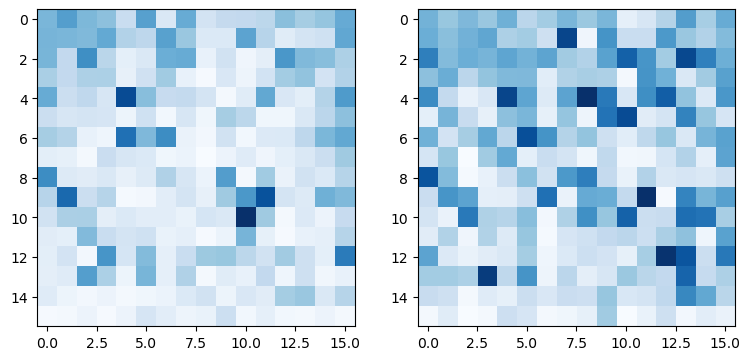

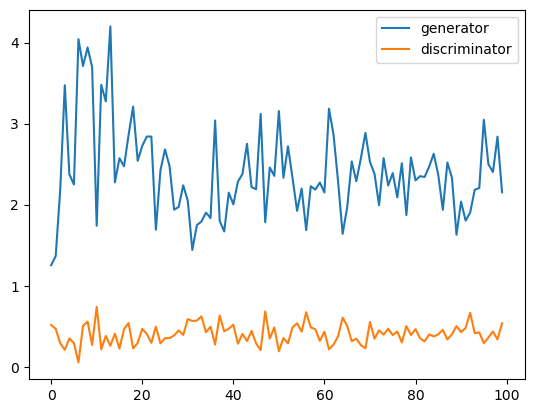

1/1 [==============================] - 0s 28ms/step


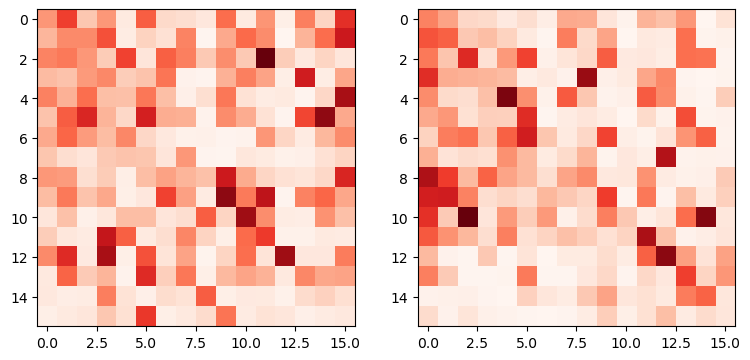

1/1 [==============================] - 0s 28ms/step


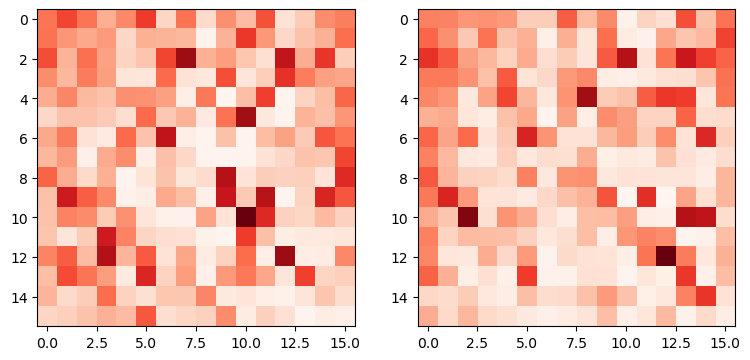

1/1 [==============================] - 0s 28ms/step


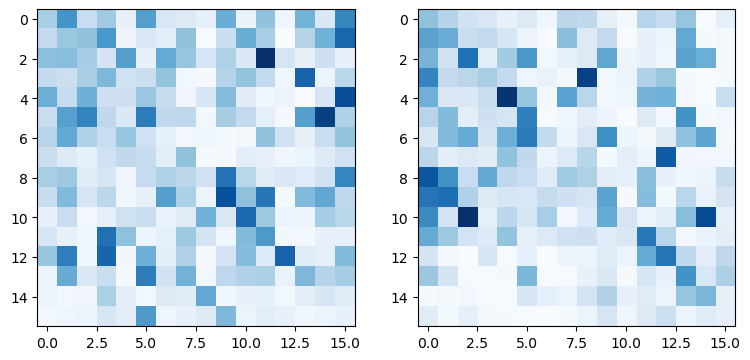

1/1 [==============================] - 0s 29ms/step


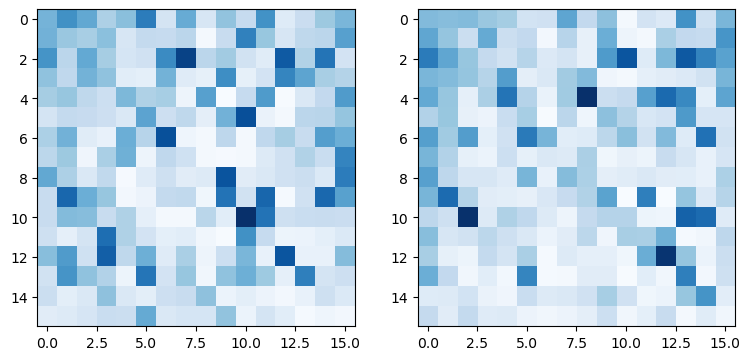

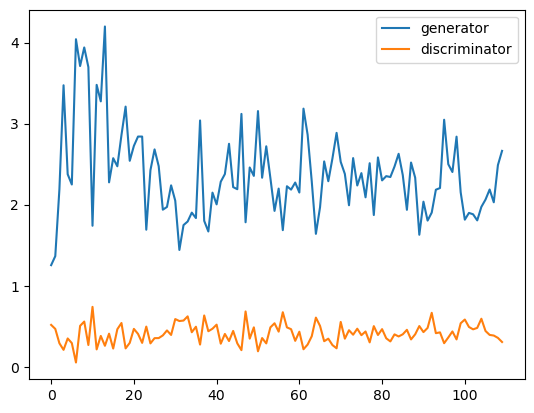

1/1 [==============================] - 0s 30ms/step


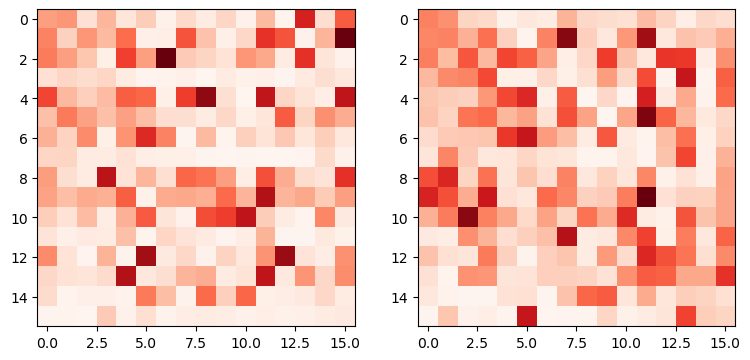

1/1 [==============================] - 0s 28ms/step


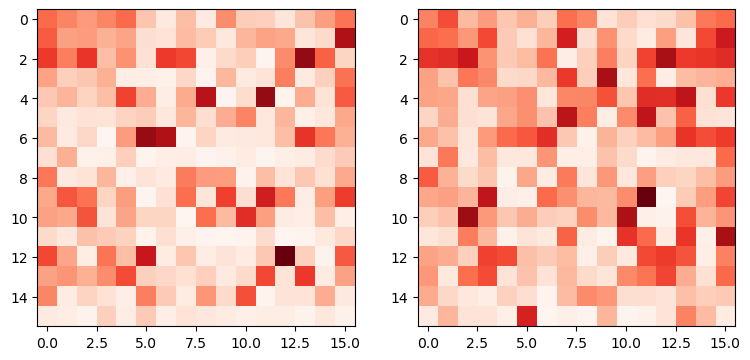

1/1 [==============================] - 0s 28ms/step


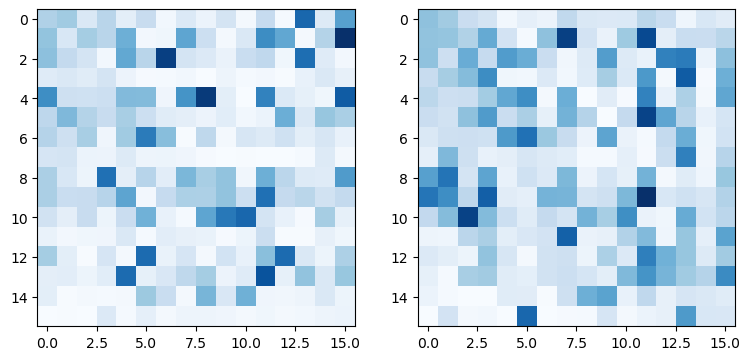

1/1 [==============================] - 0s 28ms/step


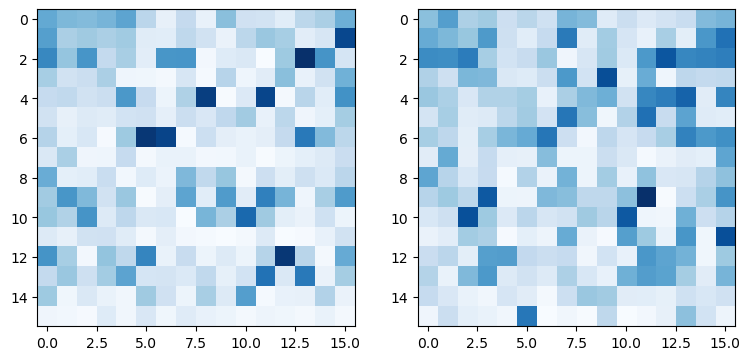

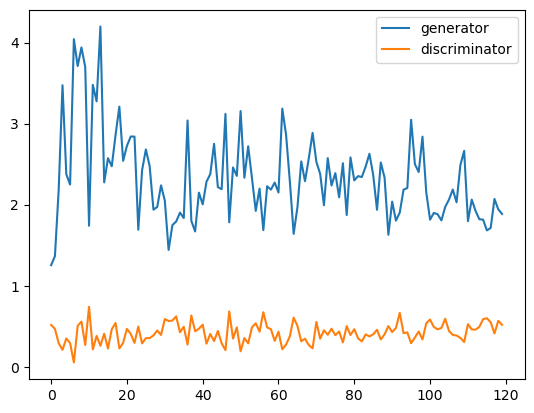

1/1 [==============================] - 0s 28ms/step


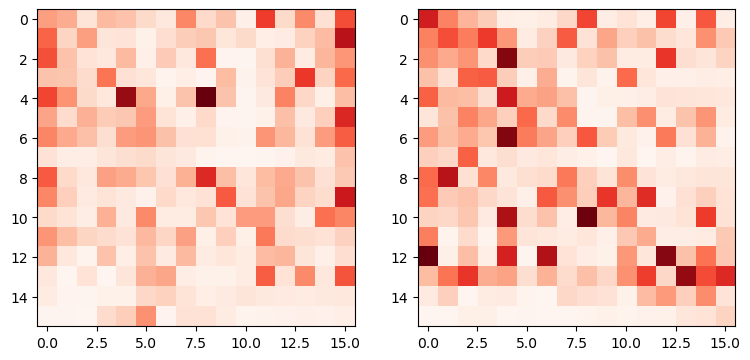

1/1 [==============================] - 0s 28ms/step


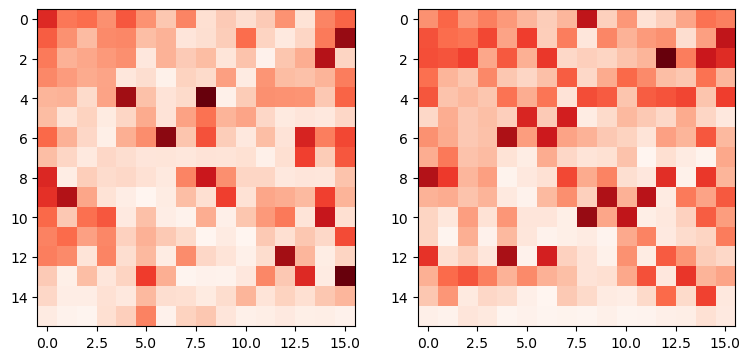

1/1 [==============================] - 0s 29ms/step


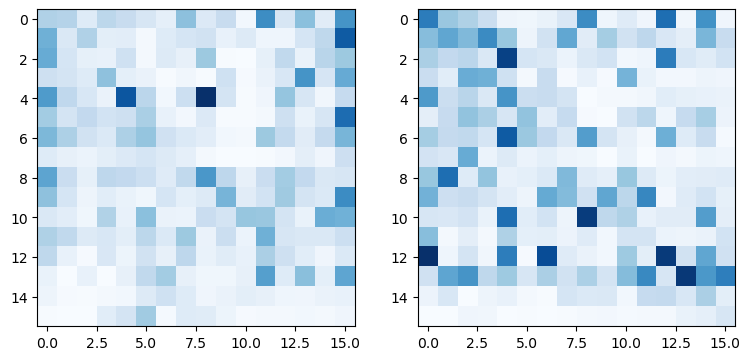

1/1 [==============================] - 0s 28ms/step


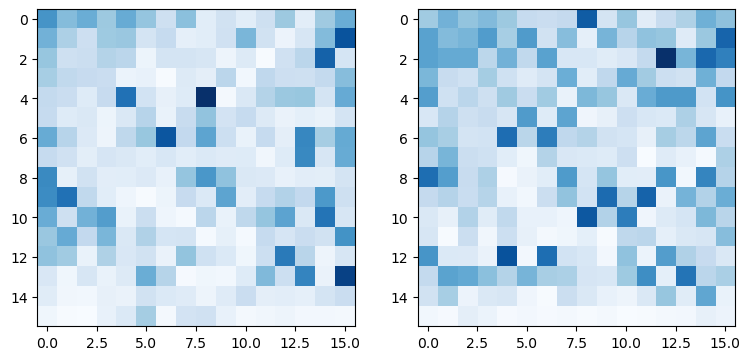

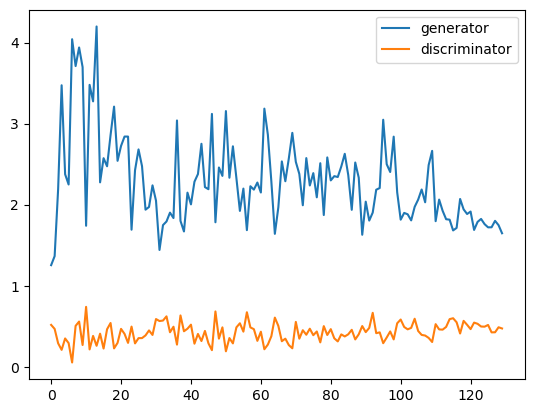

1/1 [==============================] - 0s 29ms/step


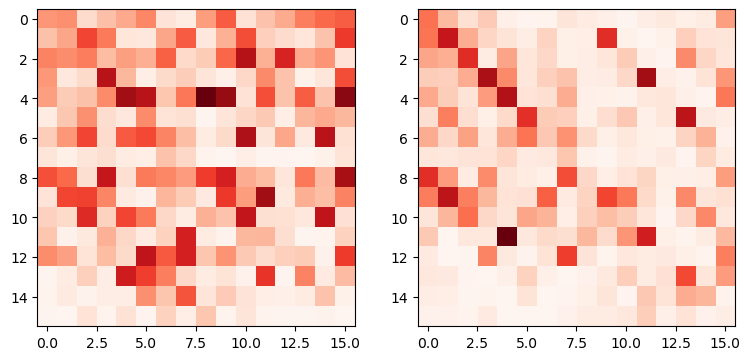

1/1 [==============================] - 0s 29ms/step


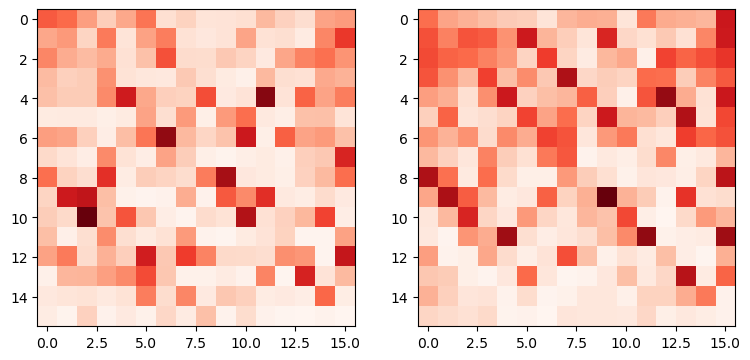

1/1 [==============================] - 0s 29ms/step


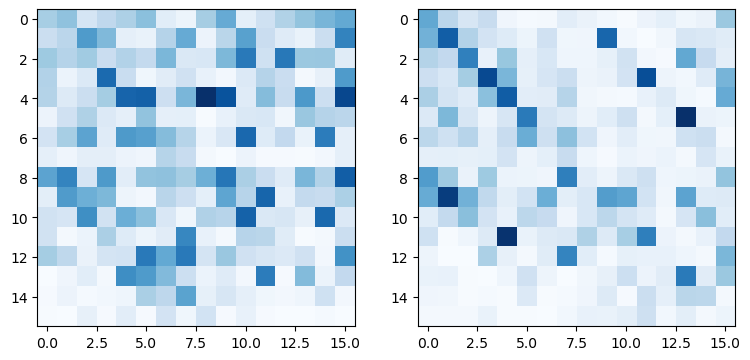

1/1 [==============================] - 0s 29ms/step


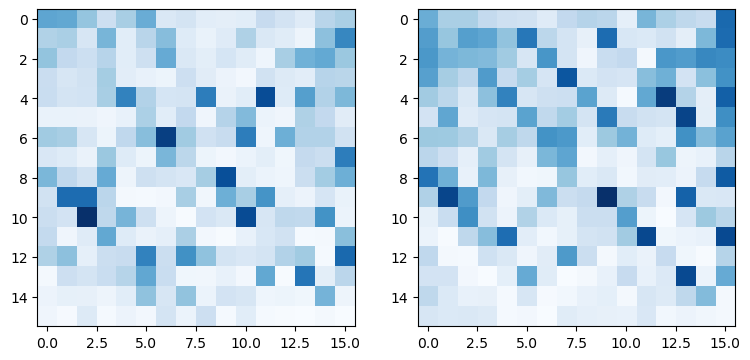

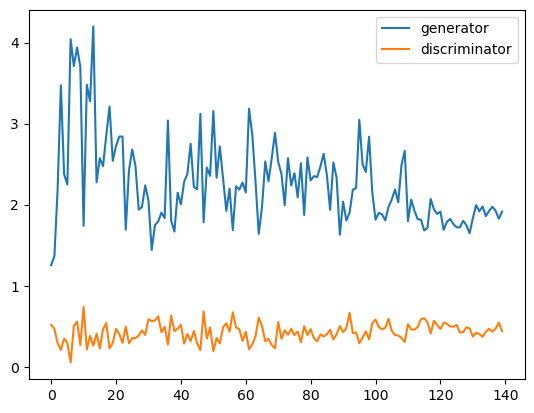

1/1 [==============================] - 0s 32ms/step


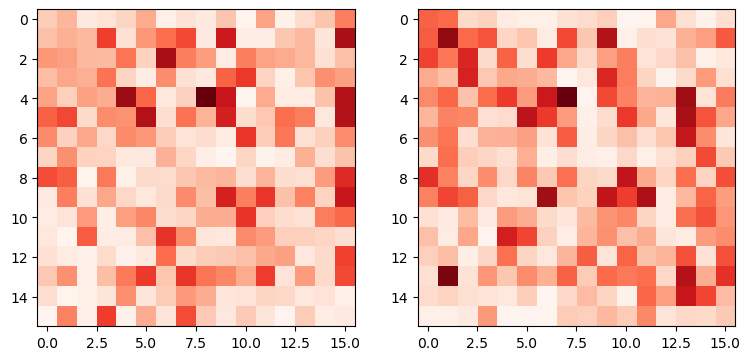

1/1 [==============================] - 0s 31ms/step


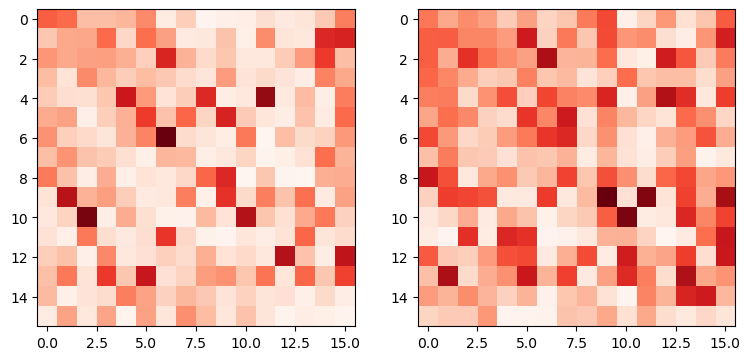

1/1 [==============================] - 0s 28ms/step


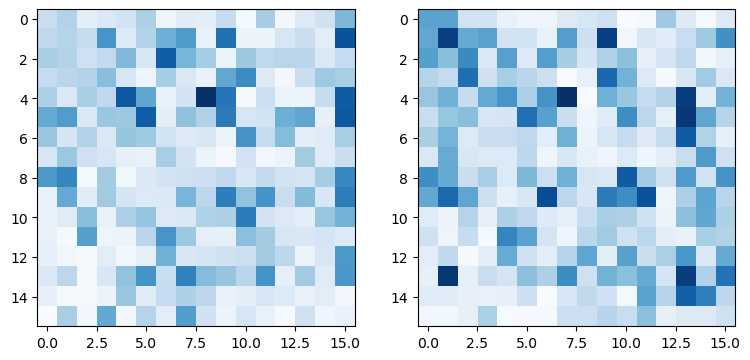

1/1 [==============================] - 0s 28ms/step


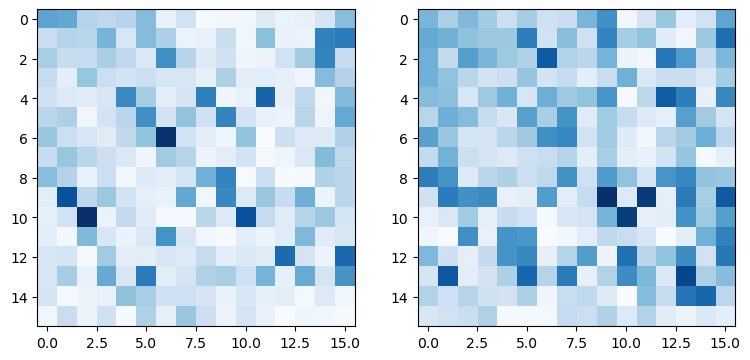

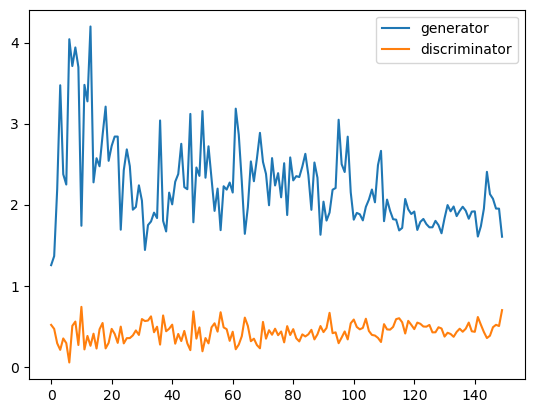

1/1 [==============================] - 0s 28ms/step


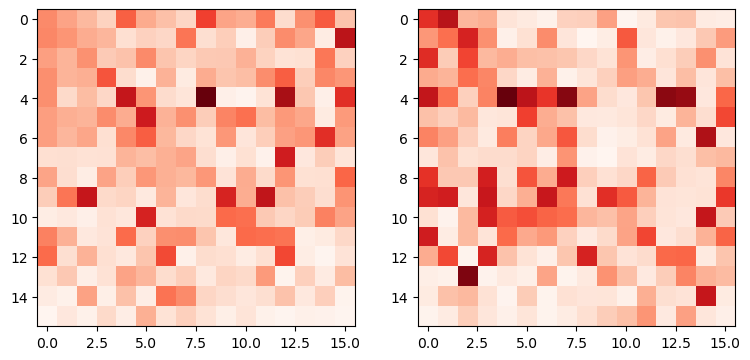

1/1 [==============================] - 0s 28ms/step


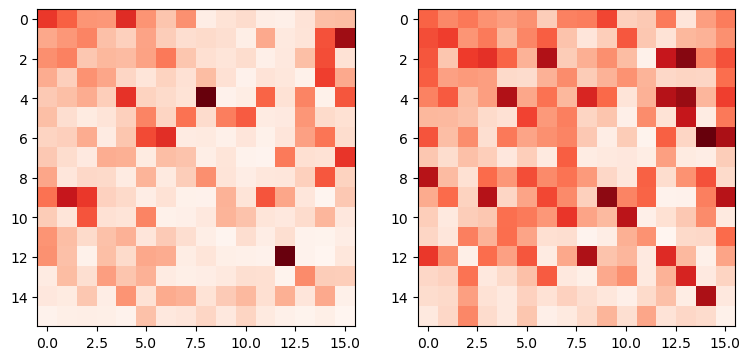

1/1 [==============================] - 0s 28ms/step


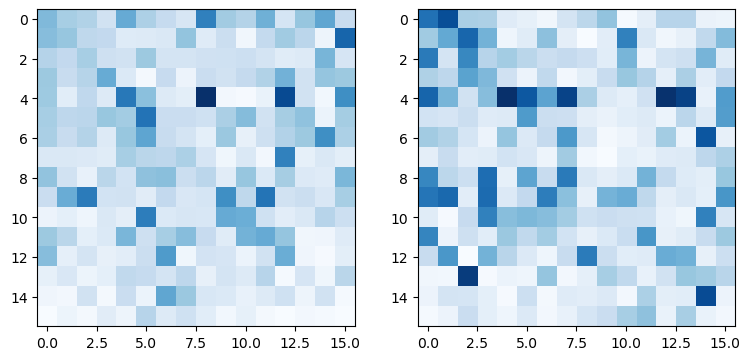

1/1 [==============================] - 0s 27ms/step


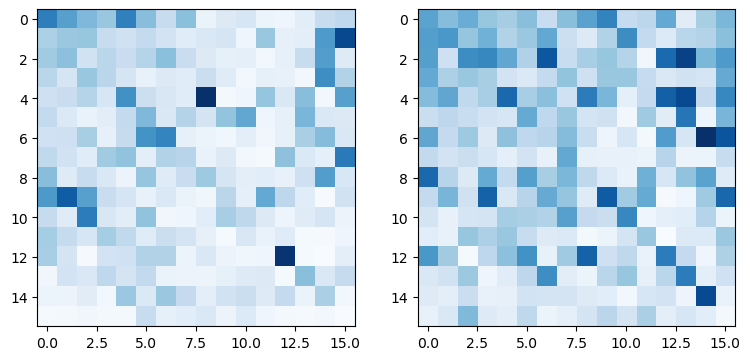

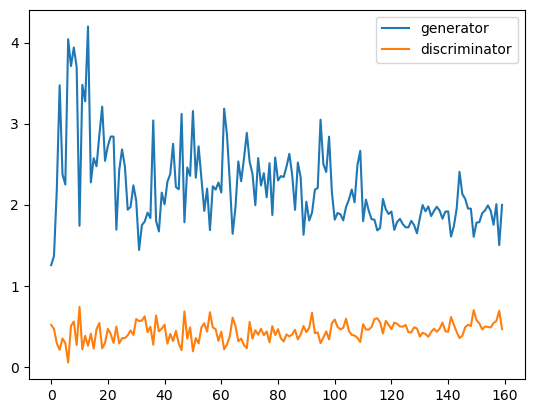

1/1 [==============================] - 0s 28ms/step


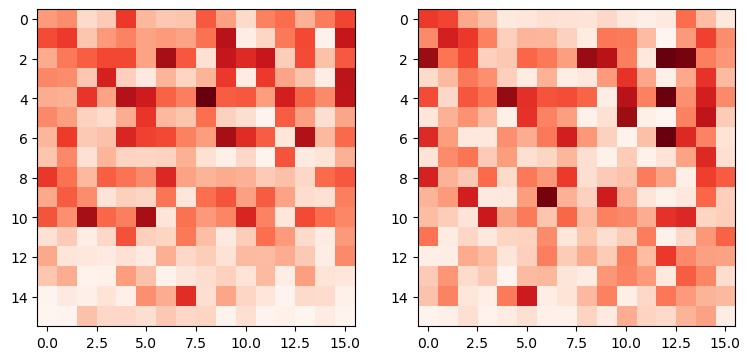

1/1 [==============================] - 0s 31ms/step


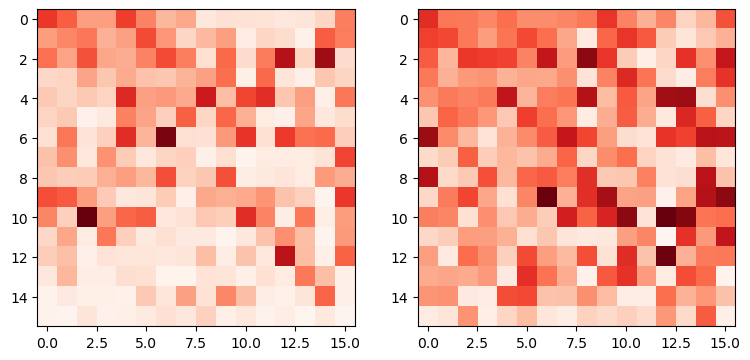

1/1 [==============================] - 0s 28ms/step


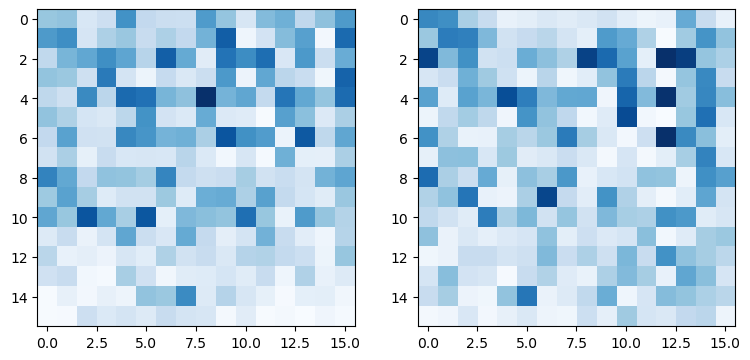

1/1 [==============================] - 0s 29ms/step


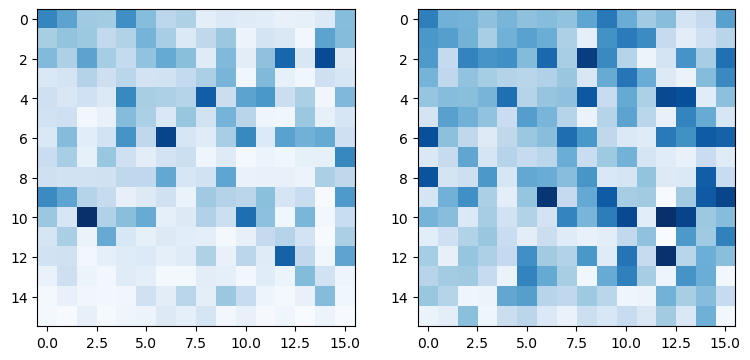

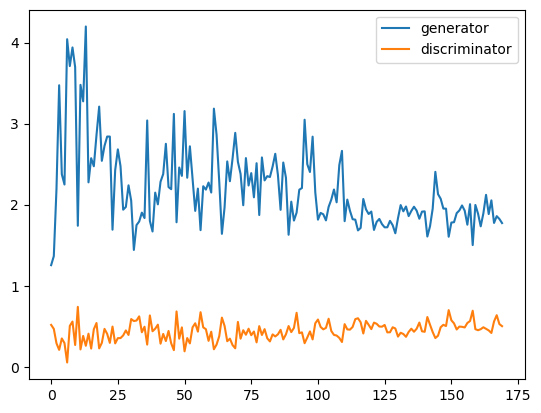

1/1 [==============================] - 0s 27ms/step


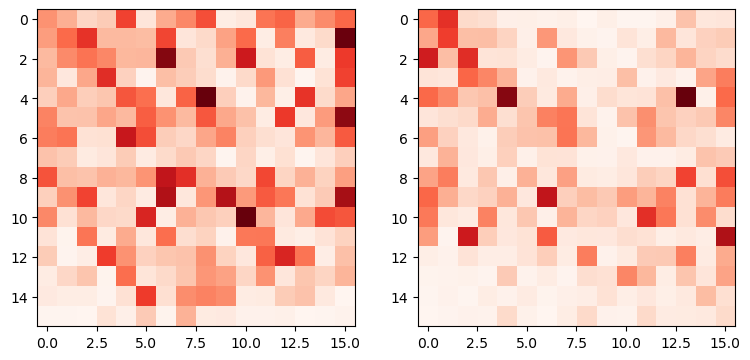

1/1 [==============================] - 0s 28ms/step


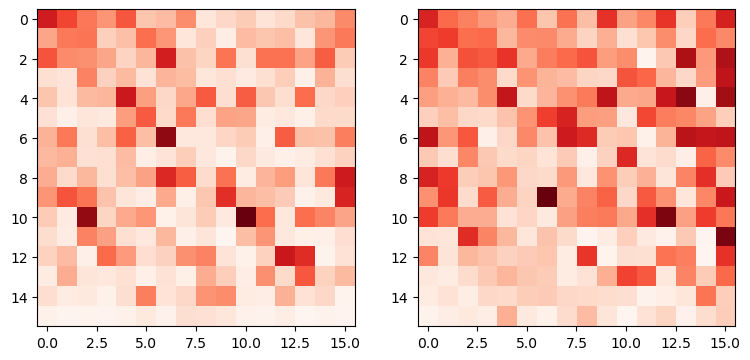

1/1 [==============================] - 0s 29ms/step


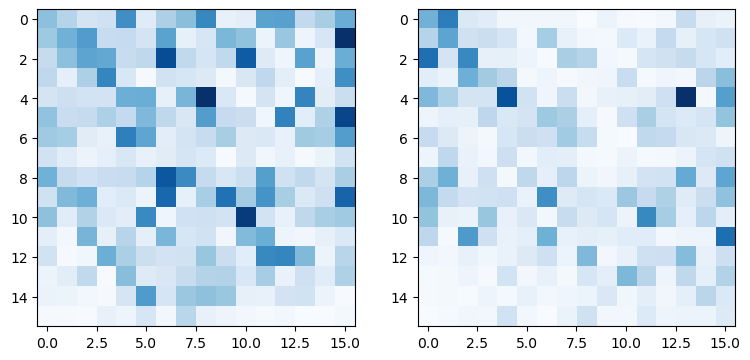

1/1 [==============================] - 0s 28ms/step


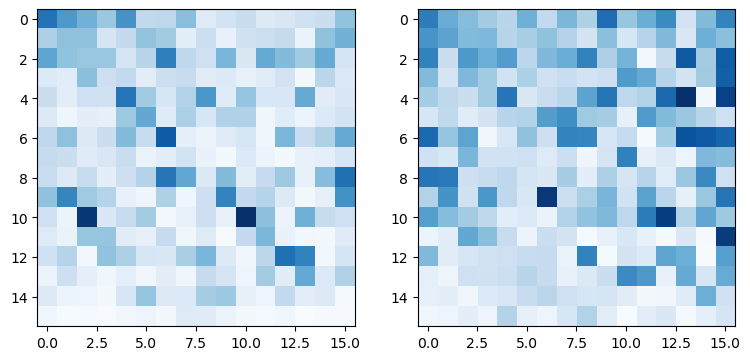

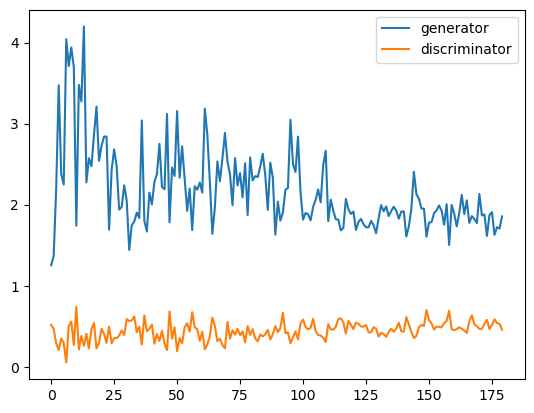

1/1 [==============================] - 0s 28ms/step


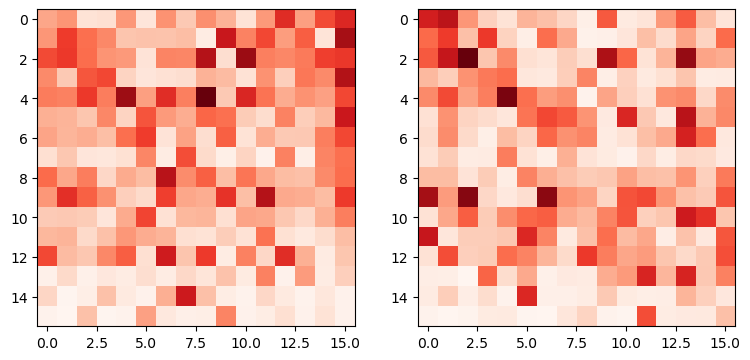

1/1 [==============================] - 0s 28ms/step


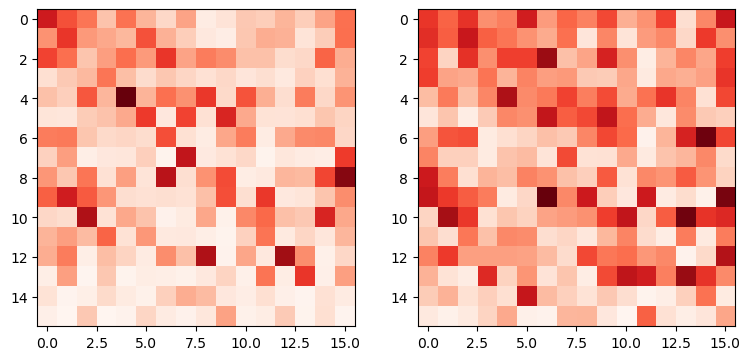

1/1 [==============================] - 0s 29ms/step


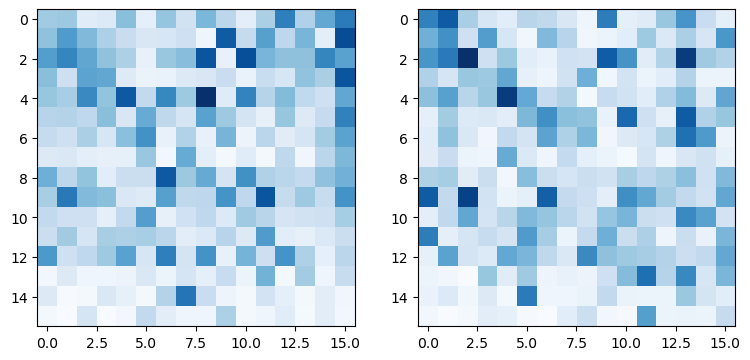

1/1 [==============================] - 0s 28ms/step


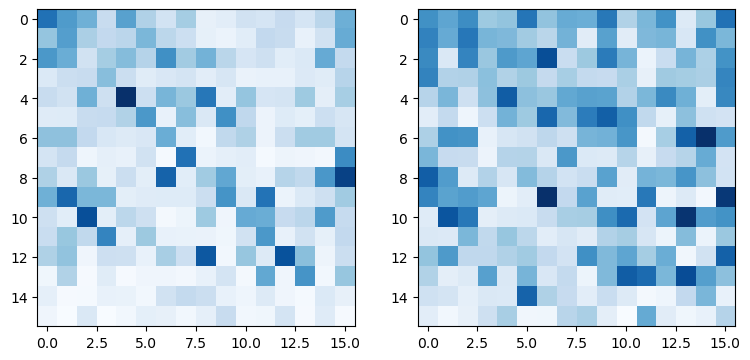

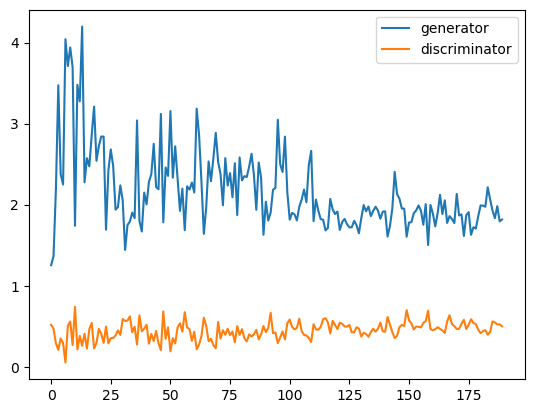

1/1 [==============================] - 0s 28ms/step


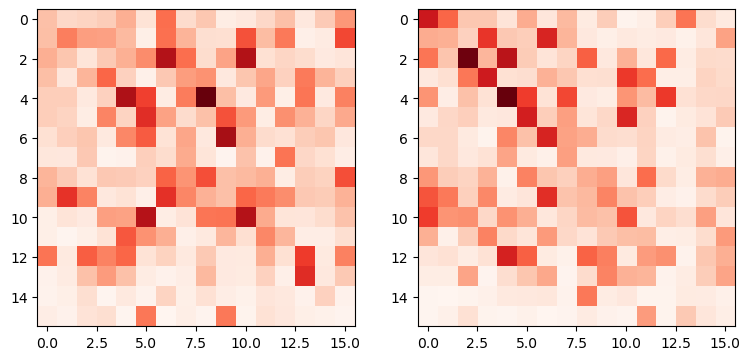

1/1 [==============================] - 0s 32ms/step


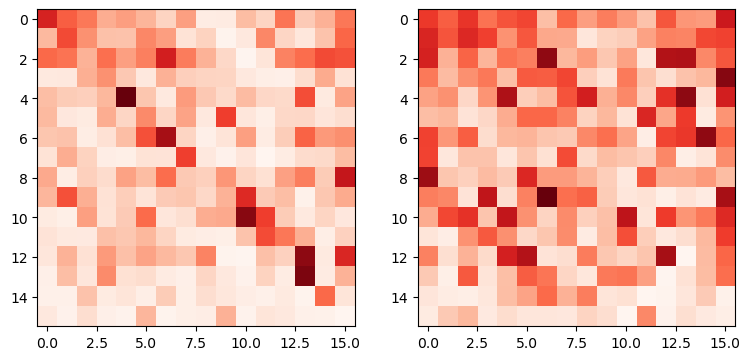

1/1 [==============================] - 0s 28ms/step


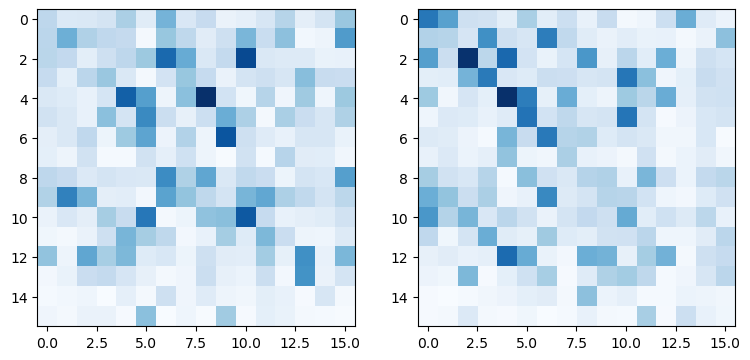

1/1 [==============================] - 0s 28ms/step


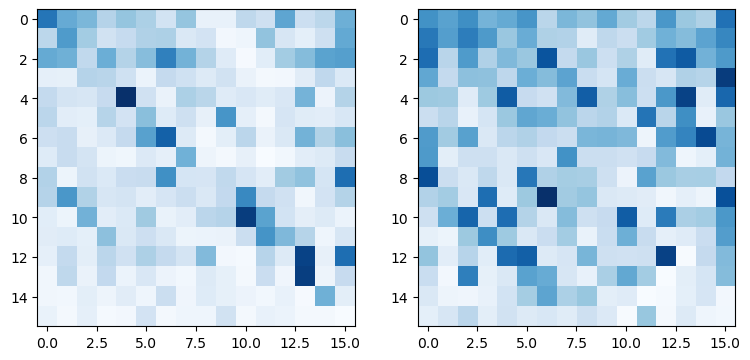

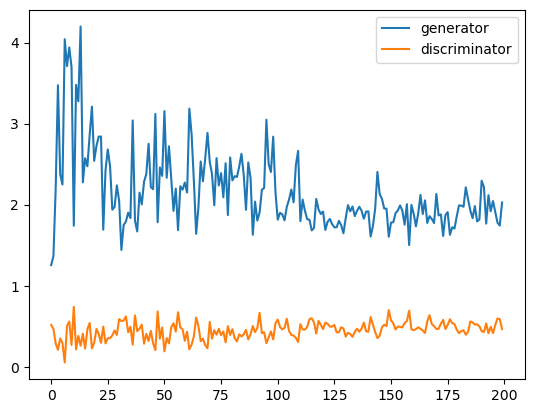

In [66]:
cond_gan = ConditionalGAN(
    discriminator=new_discriminator(), generator=new_generator(k), latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.003,beta_1=0.5,beta_2=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5,beta_2=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)
g_loss=[]
d_loss=[]
for i in range(20):
    out=cond_gan.fit(dataset, epochs=10, shuffle=True, verbose=0)
    trained_gen = cond_gan.generator
    g_loss+=out.history['g_loss']
    d_loss+=out.history['d_loss']
    make_fake_image(0,seed=0)
    make_fake_image(0,seed=1)
    make_fake_image(1,seed=0)
    make_fake_image(1,seed=1)
    plt.plot(g_loss)
    plt.plot(d_loss)
    plt.legend(['generator','discriminator'])
    plt.show()

In [69]:
fake_true_retrained=[]
fake_false_retrained=[]
for j in range(20):
    out=cond_gan.fit(dataset, epochs=10, shuffle=True, verbose=0)
    trained_gen = cond_gan.generator
    for i in range(100):
        fake_true_retrained.append(make_fake_image(0,seed=i,show=False))
    for i in range(100,200):
        fake_false_retrained.append(make_fake_image(1,seed=i,show=False))
fake_true_retrained = np.array(fake_true_retrained).squeeze()
fake_false_retrained = np.array(fake_false_retrained).squeeze()

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


In [70]:
training_images = scale_cgrs(data['training_x'])
training_labels = data['training_y']
real_true = training_images[training_labels==1,:,:,:]
real_false = training_images[training_labels==0,:,:,:]
fake_true_retrained_x = fake_true_retrained
fake_true_retrained_y = np.ones((len(fake_true_retrained)))
fake_false_retrained_x = fake_false_retrained
fake_false_retrained_y = np.zeros((len(fake_false_retrained)))
fake_combined_x = np.concatenate((fake_true_retrained, fake_false_retrained),axis=0)
fake_combined_y = np.concatenate((fake_true_retrained_y, fake_false_retrained_y))

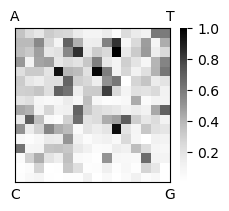

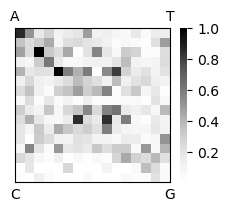

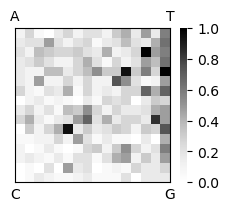

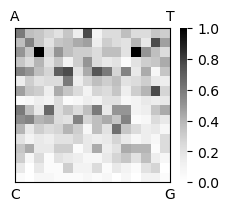

In [71]:
def draw_hm(hm):
    hm=hm/np.max(hm)
    plt.figure(figsize=(2.5,2))
    ax=sb.heatmap(hm,cmap='Greys')
    plt.xticks([0,16],['C','G'])
    plt.yticks([])
    plt.tick_params(length=0)
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks([0,16])
    ax2.set_xticklabels(['A','T'])
    plt.tick_params(length=0)
    plt.show()

draw_hm(fake_true_retrained[0,:,:,0])
draw_hm(fake_true_retrained[0,:,:,1])
draw_hm(real_true[0,:,:,0])
draw_hm(real_true[0,:,:,1])

### Results

We retrained the best performing models with GAN output added to the training data, and obtained the models' performance when applied to the (real) holdout data using code like the below:

    all_results=[]
    for ind_i in inds[:num_models]:
        k,seed_i = param_list[ind_i]
        if k==4:
            data_file=f'/content/drive/My Drive/Colab_data/AtGrand/AtGrand_{k}mers.npz'
            i = seed_i
            out_filename = f'{out_folder}/AtGrand_{k}mers_{i}.csv'
            out_df = pd.read_csv(out_filename)
            print(i, out_df['seed_i'])
            params = out_df.iloc[0][1:26].to_dict()
            params['k']=k
            all_results.append(train_with_gans(params, i, data_file))
    clear_output()
    all_results_df = pd.concat(all_results)
    display(all_results_df)
    all_results_df.to_csv(f'{out_folder}/holdout_results_with_gans.csv')

In [34]:
all_results_df=pd.read_csv('data/0008_synthetic_data/gans_results/holdout_results_with_gans.csv')
all_results_nogans_df=pd.read_csv('data/0008_synthetic_data/gans_results/holdout_results.csv')

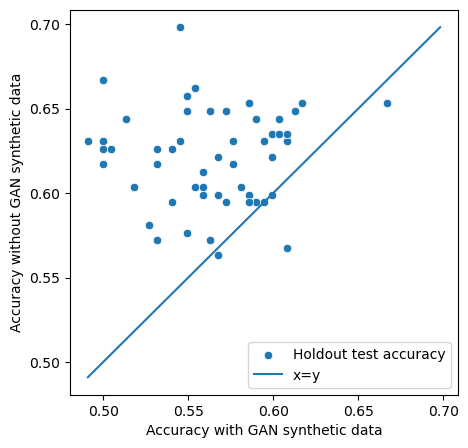

In [51]:
# Plot results of comparison
xs=[]
ys=[]
for seed_i in np.unique(all_results_df.groupby('seed_i',as_index=False).mean()['seed_i']):
    for j in range(5):
        qry=f'k==4 and seed_i=={seed_i} and seed_j=={j}'
        ys.append(float(all_results_nogans_df.query(qry)['test_accuracy']))
        xs.append(float(all_results_df.query(qry)['test_accuracy']))
plt.figure(figsize=(5,5))
a_min=np.min(xs+ys)
a_max=np.max(xs+ys)
sb.scatterplot(x=xs,y=ys)
sb.lineplot(x=[a_min,a_max],y=[a_min,a_max])
plt.xlabel('Accuracy with GAN synthetic data')
plt.ylabel('Accuracy without GAN synthetic data')
plt.legend(['Holdout test accuracy','x=y'])
plt.show()